## Week 7: Xây dựng mô hình regression với bộ csgo
- Yêu cầu tương tự như khi xây dựng mô hình classification, ngoại trừ việc thay đổi target như trong hướng dẫn

Tasks:
- Các bạn hãy bỏ đi 2 cột: team_a_rounds và team_b_rounds
- Đối với bài toán Classification, target là cột "result"
- Đối với bài toán Regression, target là cột "points"

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


from ydata_profiling import ProfileReport

In [99]:
df = pd.read_csv('csgo.csv')
df.drop(['team_a_rounds','team_b_rounds'], axis=1, inplace=True)

In [100]:
# profile = ProfileReport(df, title="Csgo Report", explorative=True)
# profile.to_file('csgo_report.html')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   map           1133 non-null   object 
 1   day           1133 non-null   float64
 2   month         1133 non-null   float64
 3   year          1133 non-null   float64
 4   date          1133 non-null   object 
 5   wait_time_s   1133 non-null   float64
 6   match_time_s  1133 non-null   float64
 7   ping          1133 non-null   float64
 8   kills         1133 non-null   float64
 9   assists       1133 non-null   float64
 10  deaths        1133 non-null   float64
 11  mvps          1133 non-null   float64
 12  hs_percent    1133 non-null   float64
 13  points        1133 non-null   float64
 14  result        1133 non-null   object 
dtypes: float64(12), object(3)
memory usage: 132.9+ KB


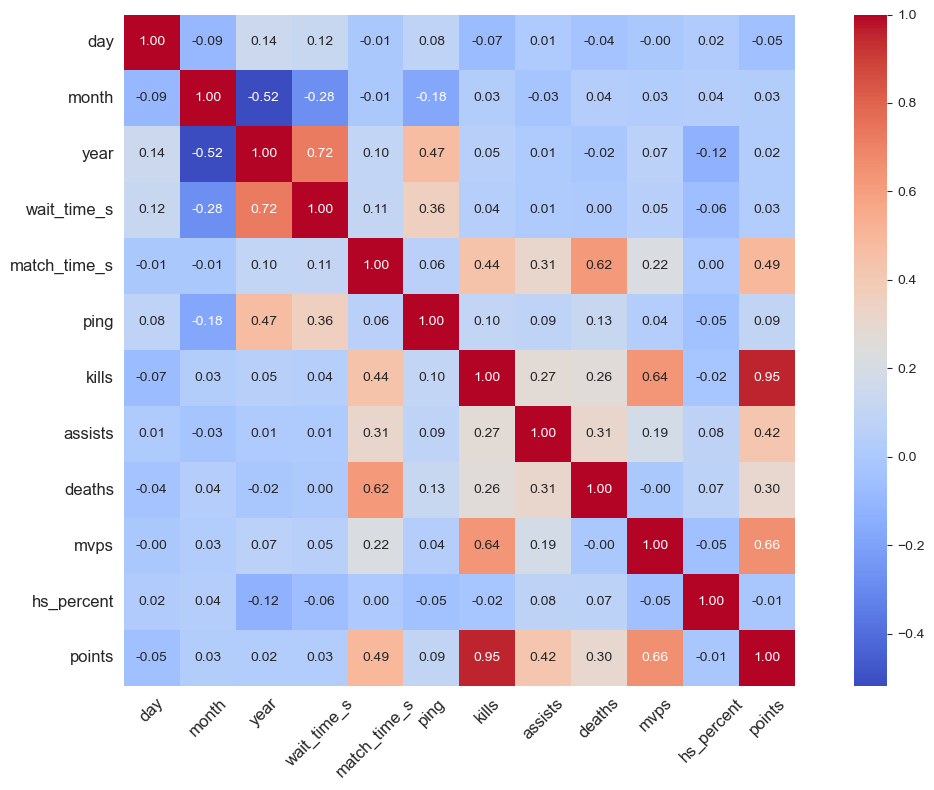

In [102]:
%matplotlib inline

temp = df.drop(['map','date','result'], axis=1, inplace = False)
corr = temp.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True,fmt='.2f',cmap='coolwarm', cbar={'shrink':0.8},linecolor='0.5',square=True)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

Nhận thấy feature kills có hệ số tương quan cao so với points, vì vậy có thể dùng mô hình tuyến tính để dự đoán điểm sau mỗi trận đấu. Đồng thời nhận thấy vì year có chỉ số tương quan cao với wait_time_s (0.72), vậy nên ta loại bỏ year để tránh trường hợp đa cộng tuyến. Đồng thời date cũng sẽ không được sử dụng trong regression

In [103]:
df.drop(['year','date'], axis = 1, inplace = True)

In [104]:
#Customer Processor để xử lý Outliers
class OutlierHandler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        self.Q1 = np.quantile(x, 0.25, axis=0)
        self.Q3 = np.quantile(x, 0.75, axis=0)
        return self
    
    def transform(self, x):
        x_clipped = np.clip(x, self.Q1, self.Q3)
        return x_clipped

In [115]:
#Tạo preprocessor pipeline để xử lý dữ liệu

csgo_maps = df['map'].unique().tolist()
nom_transformer = OneHotEncoder(categories=[csgo_maps],sparse_output = False, handle_unknown = 'ignore')

result_order = [['Lost','Tie','Win']]
ordinal_transformer = OrdinalEncoder(categories = result_order)

num_transformer = Pipeline(steps = [
    ('outlier_handler', OutlierHandler()),
    ('scaler', StandardScaler())
])

num_features = df.drop(['map', 'result', 'points'],axis = 1, inplace = False).columns.tolist()

preprocessor = ColumnTransformer(transformers = [
    ('num_feature', num_transformer, num_features),
    ('ordinal_feature', ordinal_transformer, ['result']),
    ('nom_feature', nom_transformer, ['map'])
],remainder = 'passthrough')

model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [118]:
x = df.drop('points', axis = 1, inplace = False)
y = df['points']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2024)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
print("R2: {}".format(r2_score(y_test, y_pred)))

MAE: 5.408099409293526
MSE: 52.05718464813008
R2: 0.7987094172016875


In [124]:
params = {
    "regressor__n_estimators": [20, 50, 100],
    "regressor__criterion": ["squared_error", "absolute_error", "poisson"]
}

model = Pipeline(steps=[
    ("pre_processor", preprocessor),
    ("regressor", RandomForestRegressor())
])

model_gr = GridSearchCV(estimator = model, param_grid = params, scoring='r2', cv=5,verbose=2)

In [125]:
model_gr.fit(x_train, y_train)
y_pred = model_gr.predict(x_test)
print("Best parameters: {}".format(model_gr.best_params_))
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
print("R2: {}".format(r2_score(y_test, y_pred)))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END regressor__criterion=squared_error, regressor__n_estimators=20; total time=   0.1s
[CV] END regressor__criterion=squared_error, regressor__n_estimators=20; total time=   0.0s
[CV] END regressor__criterion=squared_error, regressor__n_estimators=20; total time=   0.0s
[CV] END regressor__criterion=squared_error, regressor__n_estimators=20; total time=   0.0s
[CV] END regressor__criterion=squared_error, regressor__n_estimators=20; total time=   0.0s
[CV] END regressor__criterion=squared_error, regressor__n_estimators=50; total time=   0.1s
[CV] END regressor__criterion=squared_error, regressor__n_estimators=50; total time=   0.1s
[CV] END regressor__criterion=squared_error, regressor__n_estimators=50; total time=   0.1s
[CV] END regressor__criterion=squared_error, regressor__n_estimators=50; total time=   0.1s
[CV] END regressor__criterion=squared_error, regressor__n_estimators=50; total time=   0.1s
[CV] END regressor__